# ***Mapa de característicos***
En las redes neuronales convolucionales (CNN) utilizadas en visión por ordenador, un mapa de características, también conocido como mapa de características convolucional o mapa de activación, es una matriz o cuadrícula bidimensional de números resultante de la aplicación de filtros convolucionales (también llamados kernels) a una imagen de entrada o a un mapa de características de una capa anterior. Los mapas de característicos se encargan de detectar diferentes aspectos visuales o patrones en los datos de entrada.

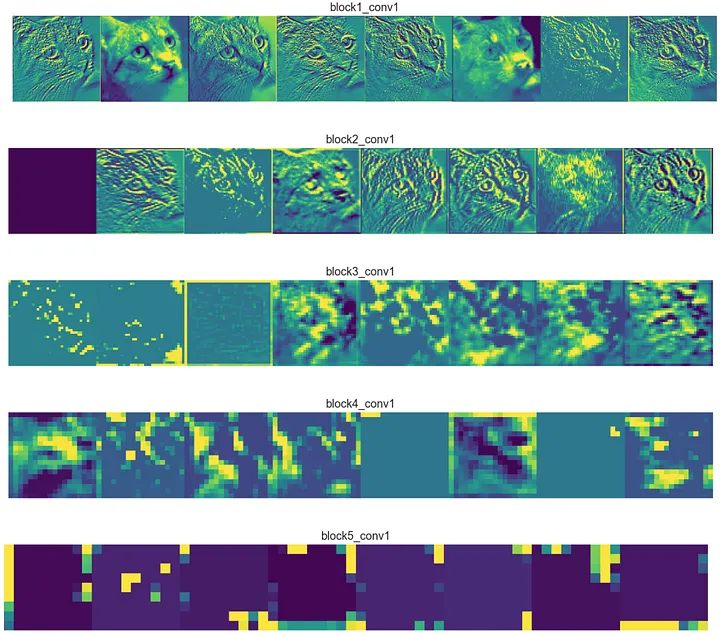

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [5]:
trainset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

trainloader = DataLoader(trainset, batch_size=8, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 477kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.76MB/s]


In [53]:
dataiter = iter(trainloader)
imagenes, labels = next(dataiter)

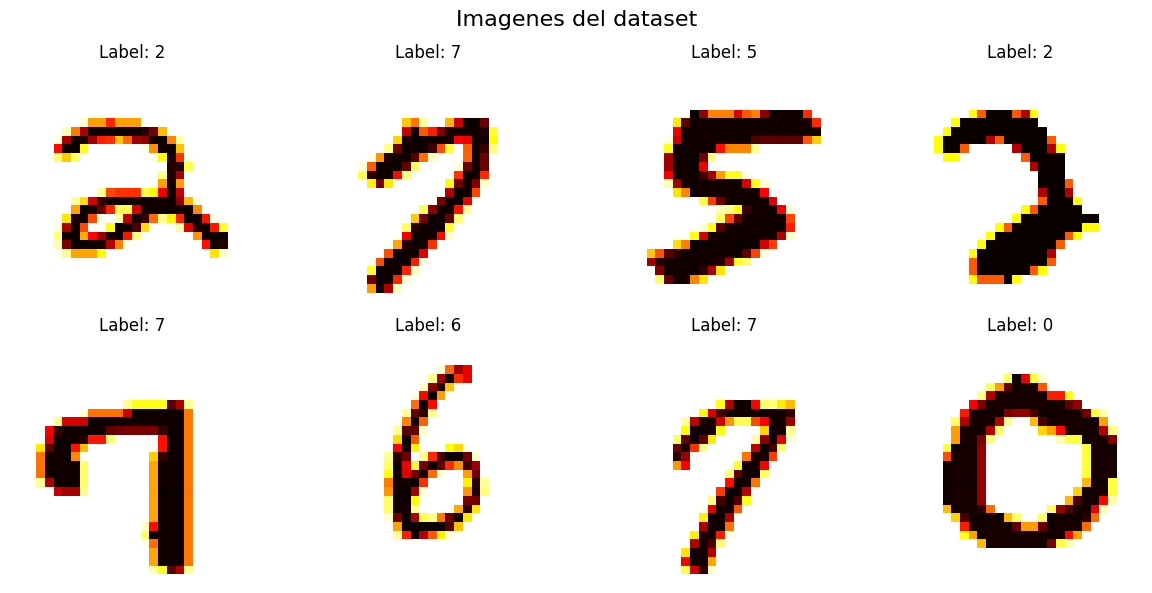

In [14]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle('Imagenes del dataset', fontsize=16)
for i in range(8):
  row = i // 4
  col = i % 4
  img = images[i].squeeze().numpy()
  axes[row, col].imshow(img, cmap='hot_r')
  axes[row, col].set_title(f'Label: {labels[i].item()}')
  axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [45]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, 1, 2)
        self.conv2 = nn.Conv2d(16, 32, 5, 1, 2)
        self.conv3 = nn.Conv2d(32, 64, 5, 1, 2)
        self.fc1 = nn.Linear(64 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def visualizar_filtros(capa, nombre_capa):
    filtros = capa.weight.data.cpu().numpy()
    num_filtros = filtros.shape[0]

    fig, ejes = plt.subplots(4, 4, figsize=(10, 10))
    fig.suptitle(f'Filtros de {nombre_capa}', fontsize=16)

    for i, ax in enumerate(ejes.flat):
        if i < min(16, num_filtros):
            if filtros.shape[1] == 1:
                ax.imshow(filtros[i, 0, :, :], cmap='gray')
            else:
                filtro_rgb = np.transpose(filtros[i, :3, :, :], (1, 2, 0))
                filtro_rgb = (filtro_rgb - filtro_rgb.min()) / (filtro_rgb.max() - filtro_rgb.min())
                ax.imshow(filtro_rgb)
            ax.set_title(f'Filtro {i}')
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

def visualizar_mapas_caracteristicos(mapas_caracteristicos, nombre_capa):
    mapas_caracteristicos = mapas_caracteristicos.cpu().detach().numpy()
    num_mapas = mapas_caracteristicos.shape[1]

    if num_mapas >= 16:
        filas, columnas = 4, 4
        mapas_a_mostrar = 16
    else:
        filas = int(np.sqrt(num_mapas))
        columnas = int(np.ceil(num_mapas / filas))
        mapas_a_mostrar = num_mapas

    fig, ejes = plt.subplots(filas, columnas, figsize=(12, 12))
    fig.suptitle(f'Mapas de características de {nombre_capa}', fontsize=16)

    if filas == 1:
        ejes = ejes.reshape(1, -1)
    if columnas == 1:
        ejes = ejes.reshape(-1, 1)

    for i in range(filas):
        for j in range(columnas):
            idx = i * columnas + j
            if idx < mapas_a_mostrar:
                ejes[i, j].imshow(mapas_caracteristicos[0, idx, :, :], cmap='viridis')
                ejes[i, j].set_title(f'Mapa {idx}')
                ejes[i, j].axis('off')
            else:
                ejes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

def obtener_mapas_caracteristicos(modelo, x):
    mapas_caracteristicos = {}
    x = x

    x = F.relu(modelo.conv1(x))
    mapas_caracteristicos['conv1'] = x.clone()
    x = modelo.pool(x)

    x = F.relu(modelo.conv2(x))
    mapas_caracteristicos['conv2'] = x.clone()
    x = modelo.pool(x)

    x = F.relu(modelo.conv3(x))
    mapas_caracteristicos['conv3'] = x.clone()
    x = modelo.pool(x)

    return mapas_caracteristicos

In [46]:
modelo = CNN()

Filtros de cada  capa:


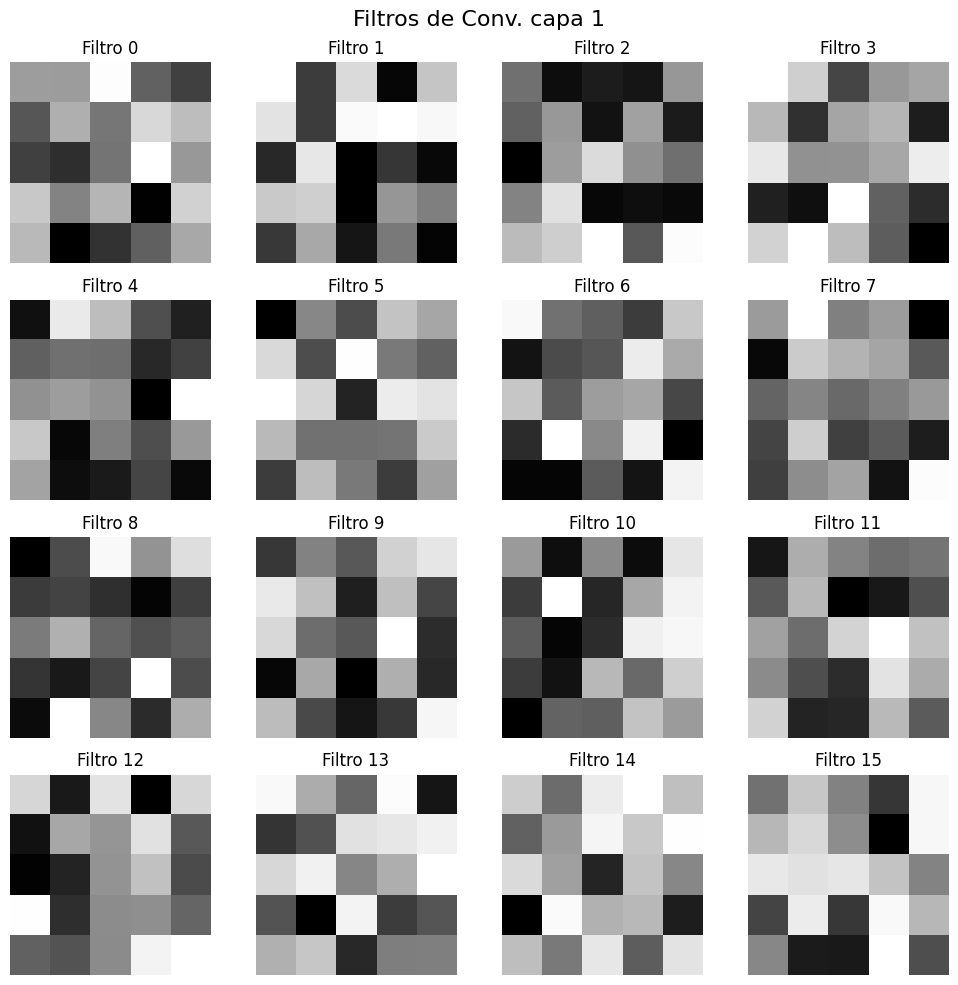

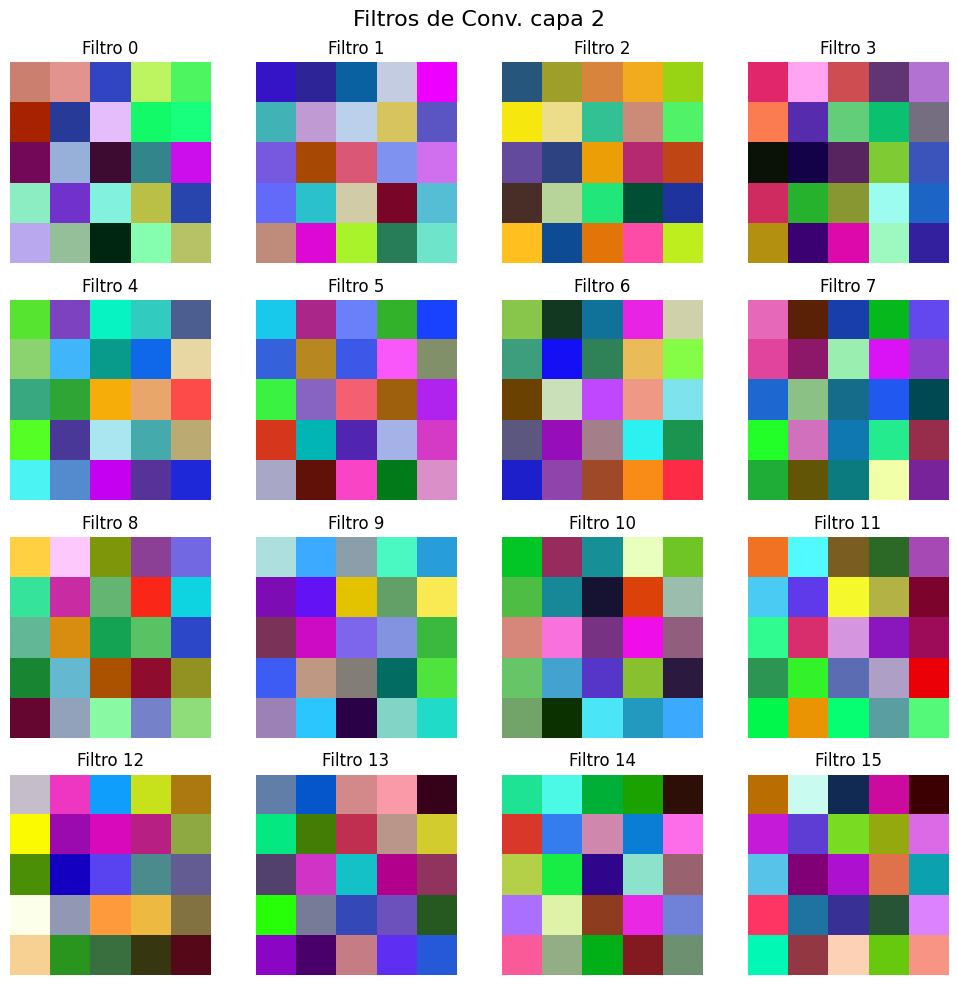

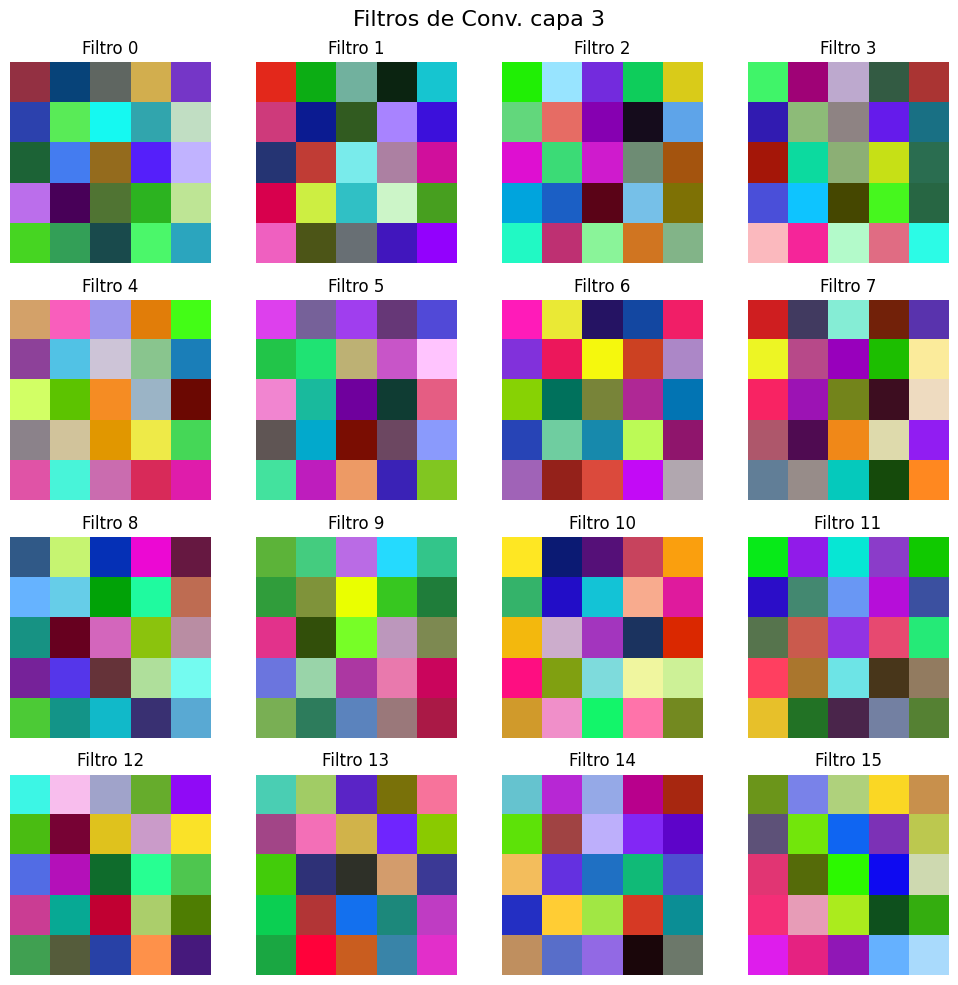

In [47]:
print("Filtros de cada  capa:")
visualizar_filtros(modelo.conv1, "Conv. capa 1")
visualizar_filtros(modelo.conv2, "Conv. capa 2")
visualizar_filtros(modelo.conv3, "Conv. capa 3")

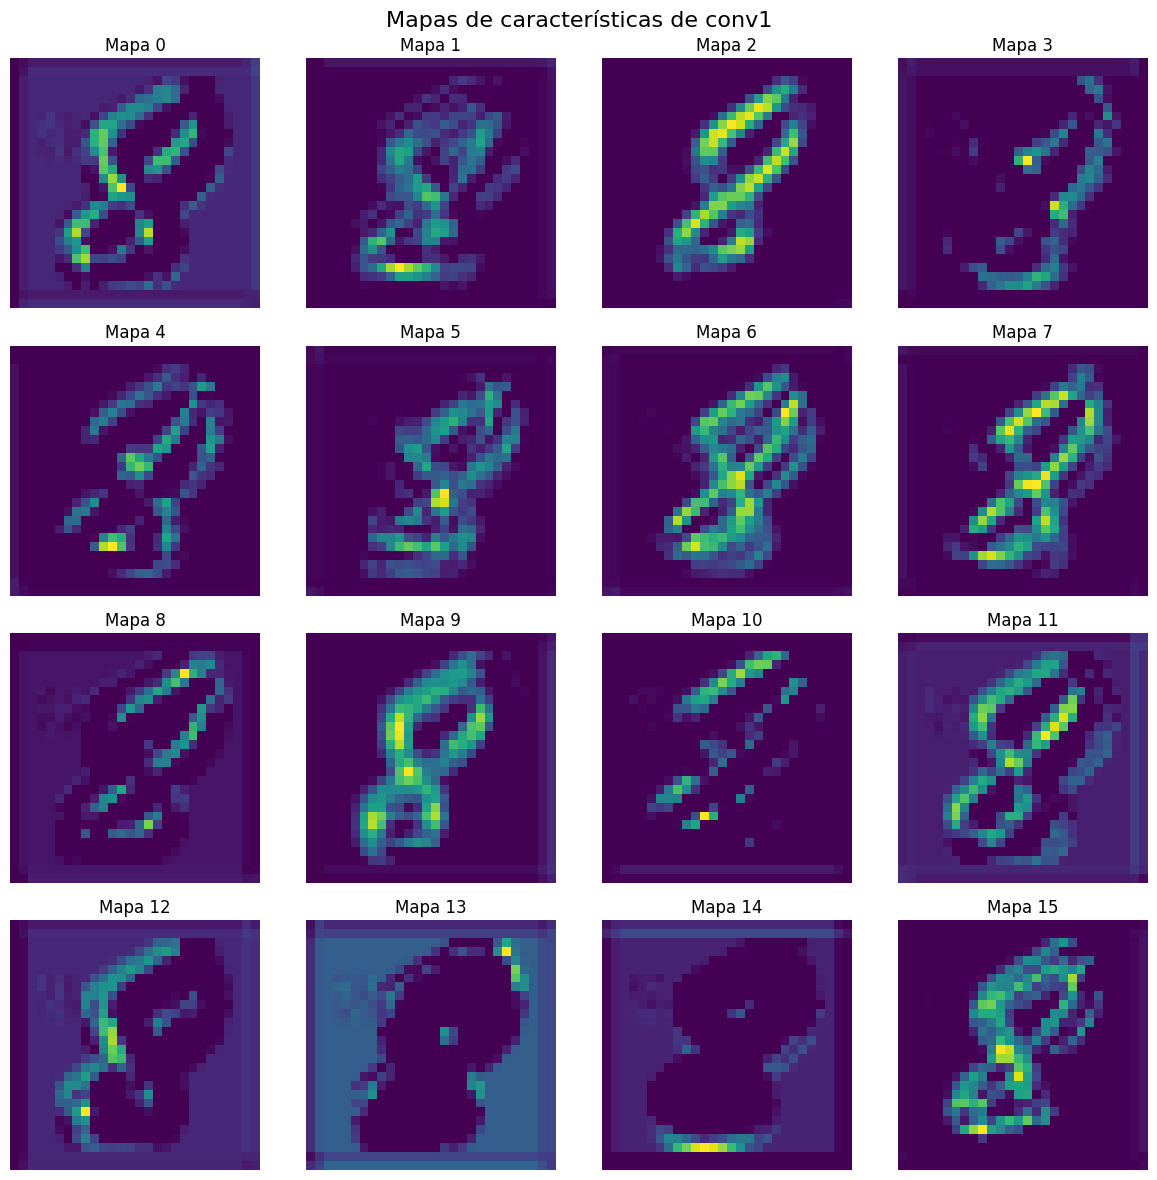

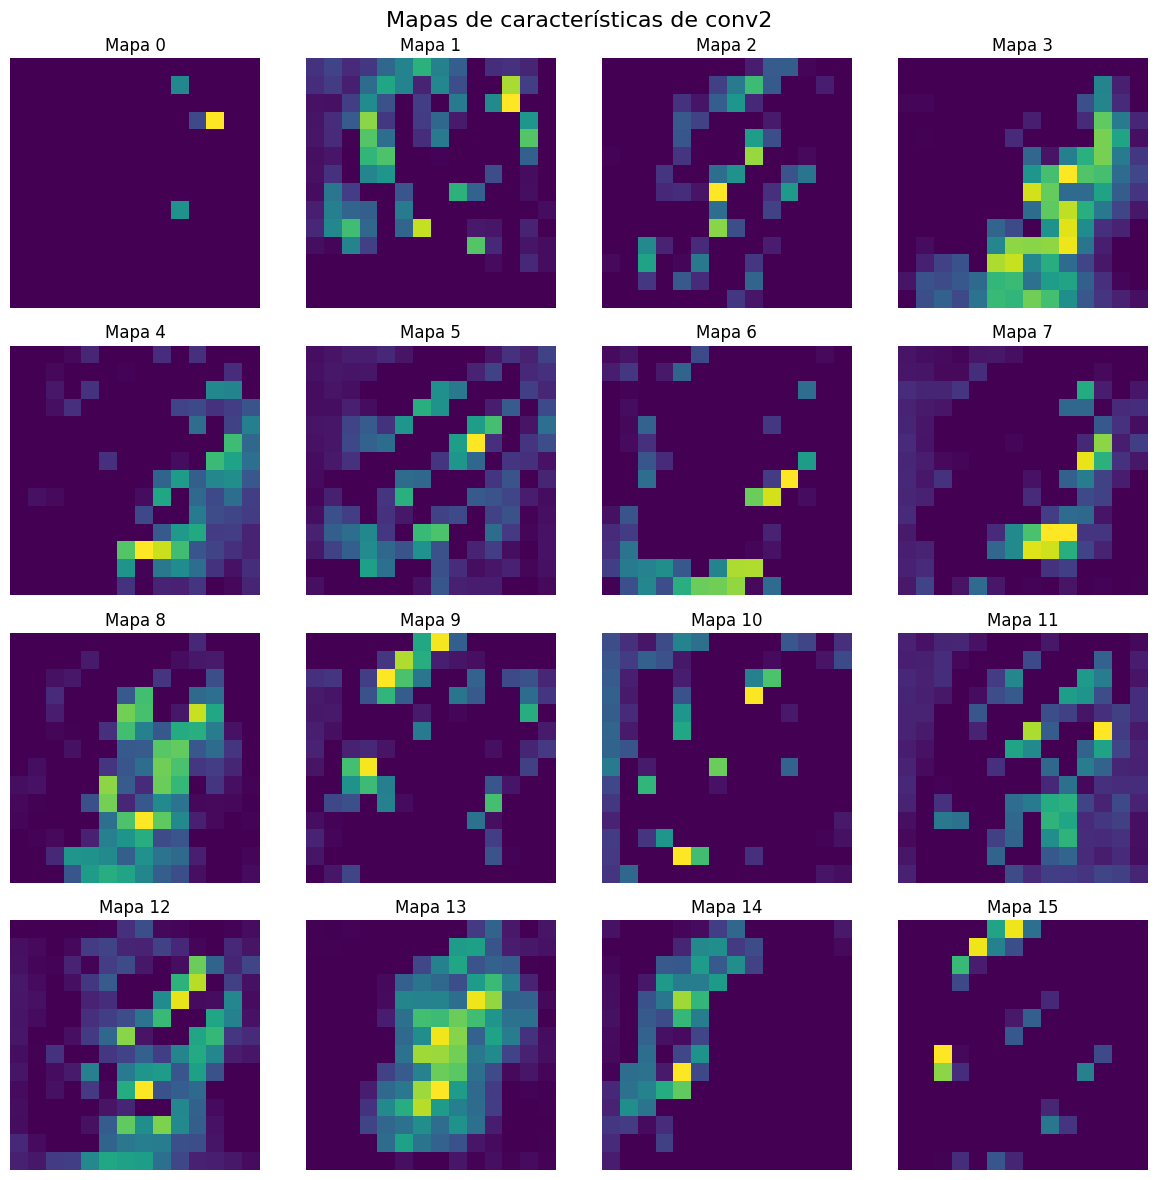

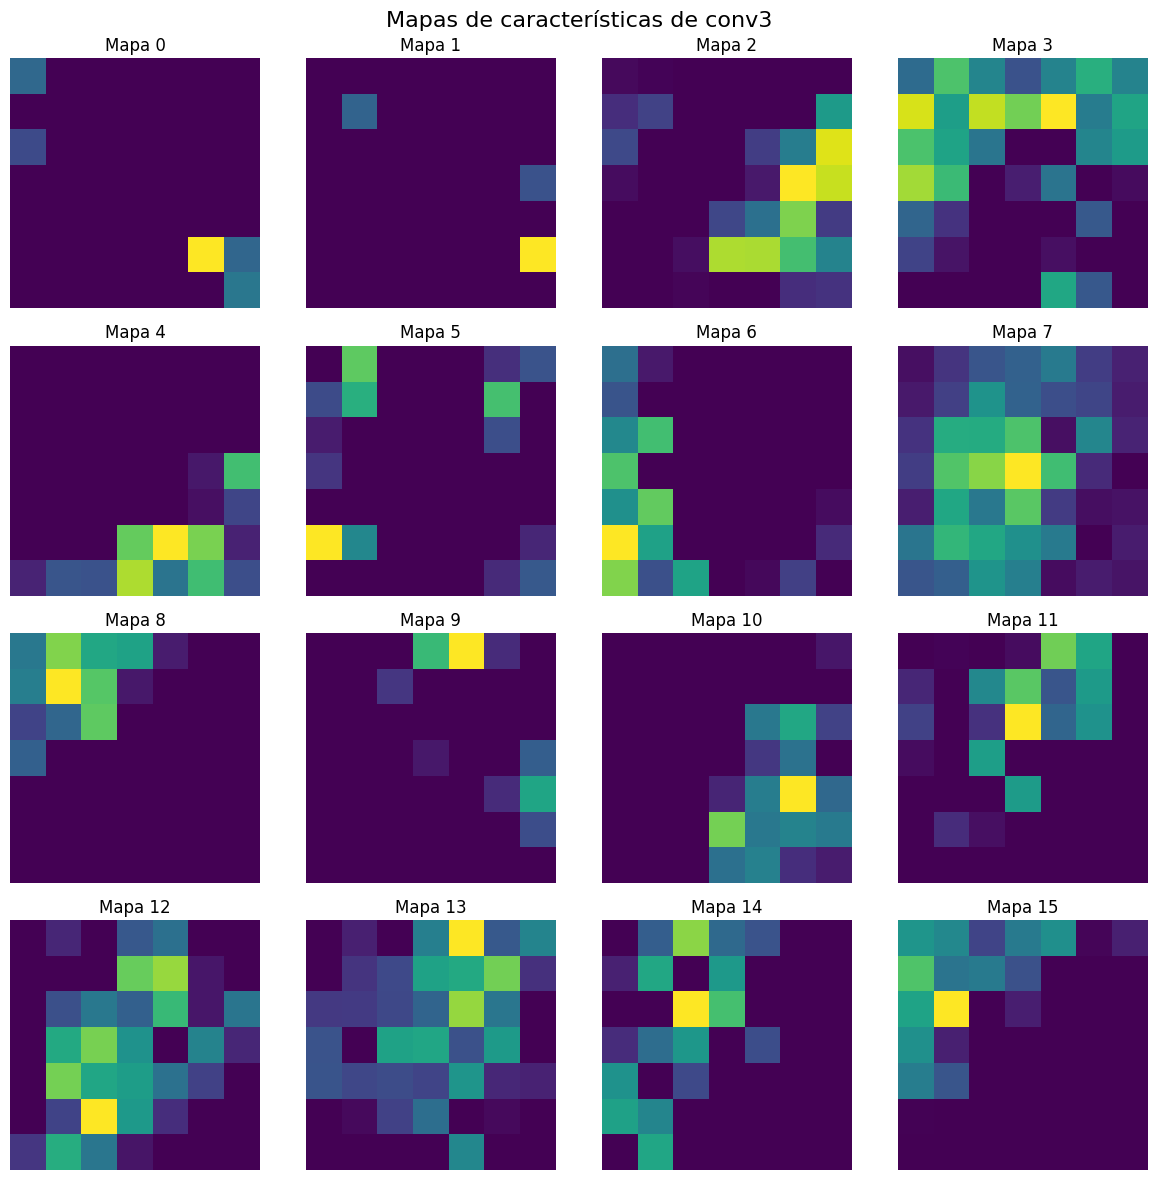

In [54]:
mapas_caracteristicos = obtener_mapas_caracteristicos(modelo, imagenes)
for nombre_capa, mapas in mapas_caracteristicos.items():
    visualizar_mapas_caracteristicos(mapas, nombre_capa)

In [59]:
imagen_muestra = imagenes[0:1]

with torch.no_grad():
    salida_conv1 = F.relu(modelo.conv1(imagen_muestra))
    pooled1 = modelo.pool(salida_conv1)
    salida_conv2 = F.relu(modelo.conv2(pooled1))
    pooled2 = modelo.pool(salida_conv2)
    salida_conv3 = F.relu(modelo.conv3(pooled2))
    pooled3 = modelo.pool(salida_conv3)

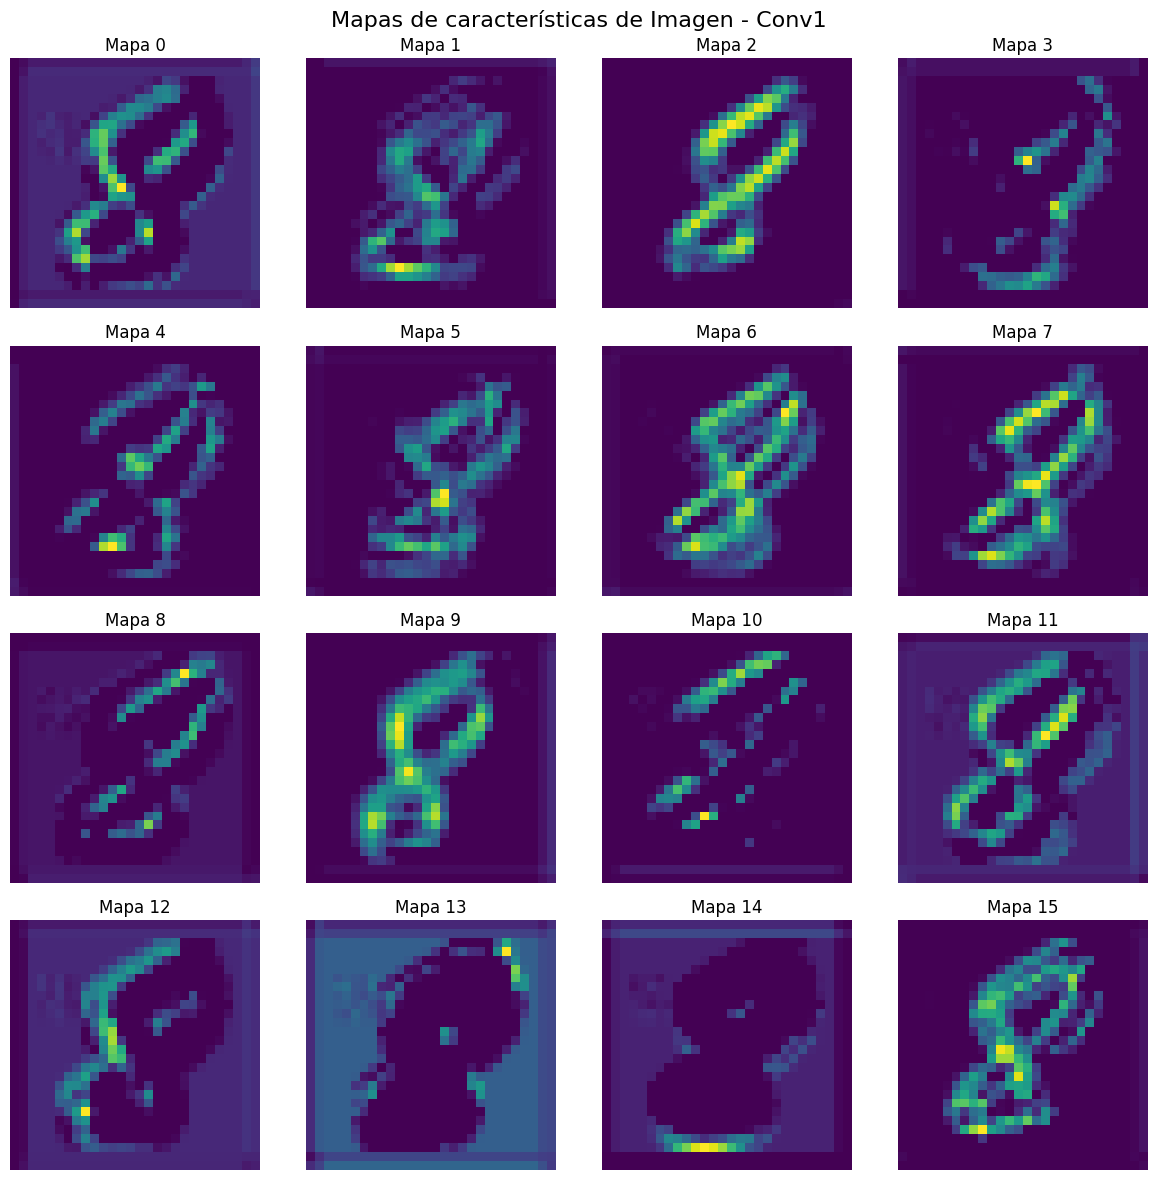

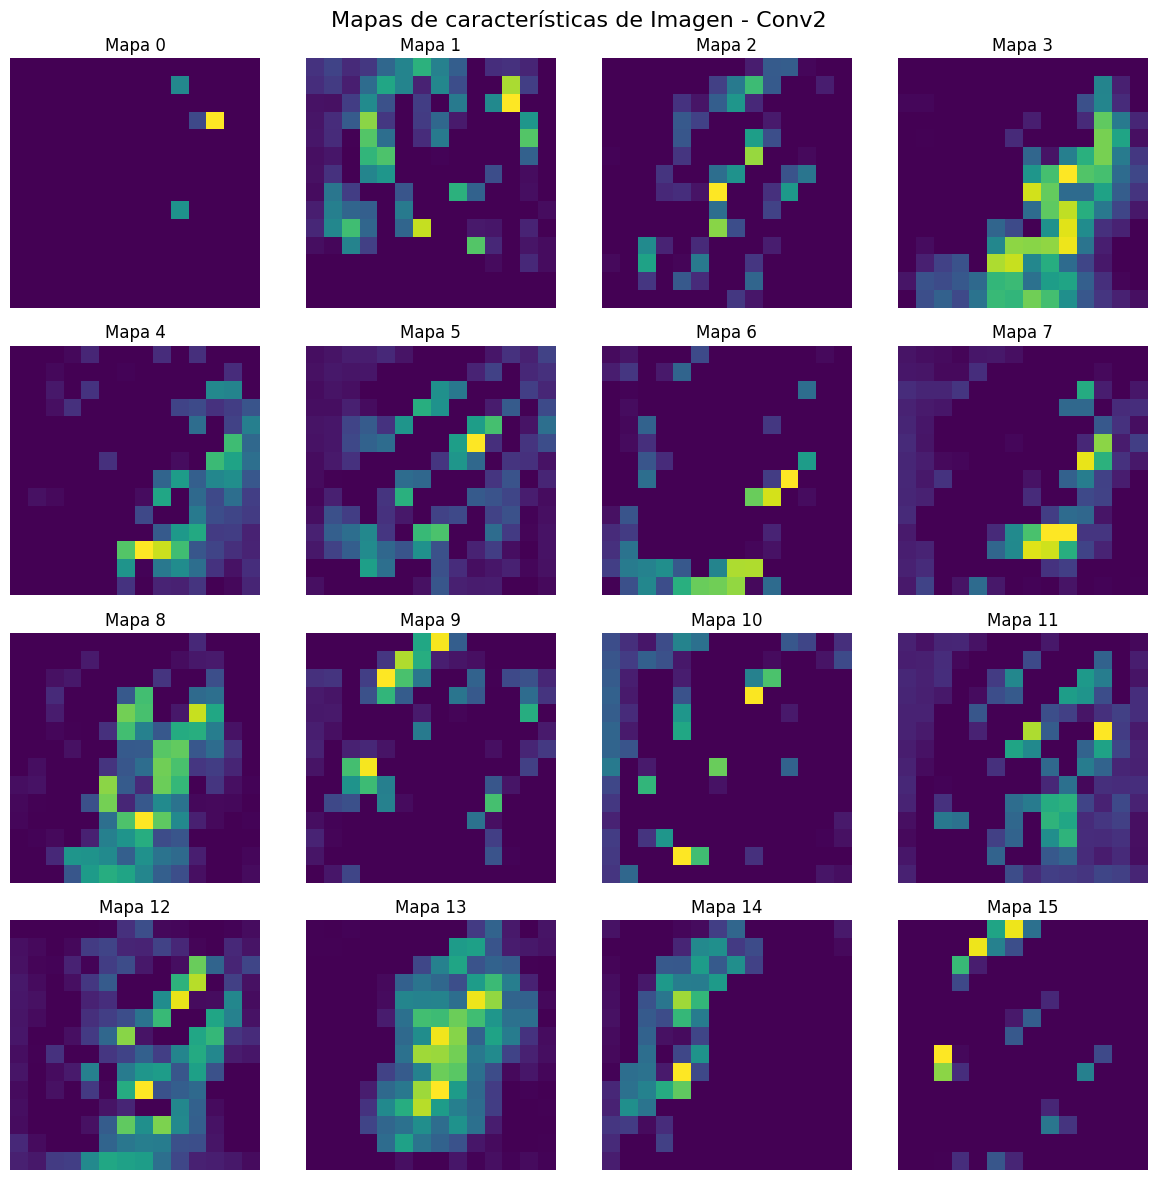

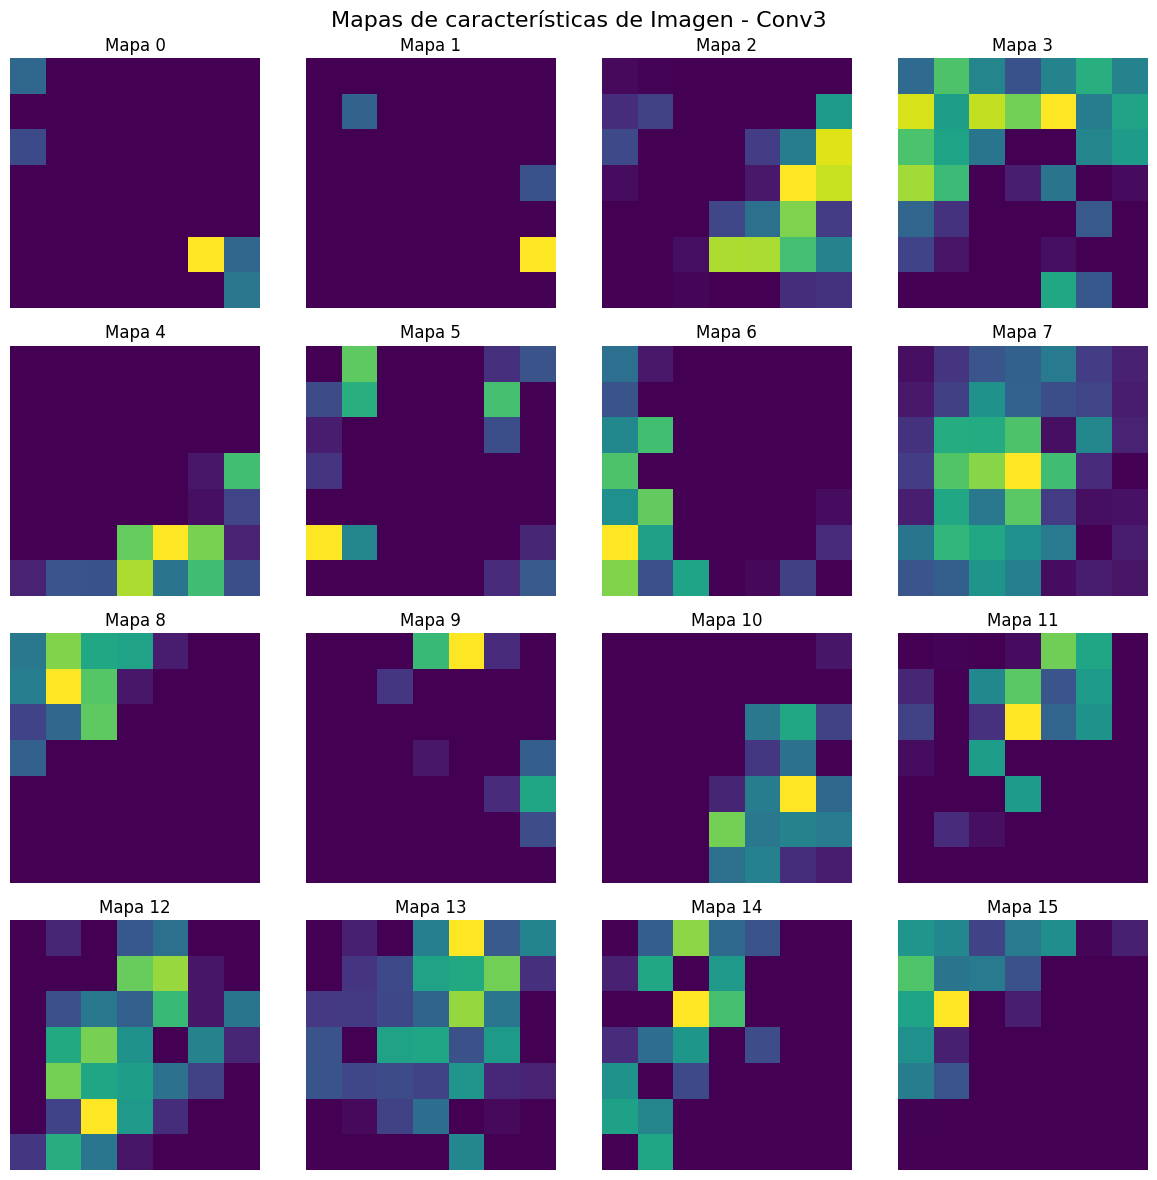

In [58]:
visualizar_mapas_caracteristicos(salida_conv1, "Imagen - Conv1")
visualizar_mapas_caracteristicos(salida_conv2, "Imagen - Conv2")
visualizar_mapas_caracteristicos(salida_conv3, "Imagen - Conv3")